# Метод главных компонент. Алгоритм k ближайших соседей 
### Олохтонова Мария 
### НПМбд-01-19

In [2]:
from sklearn.datasets import load_digits

In [3]:
digits = load_digits()

In [4]:
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

In [5]:
X = digits['data']
y = digits['target']

In [6]:
X.shape

(1797, 64)

In [7]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [8]:
from matplotlib import pyplot as plt
import numpy as np

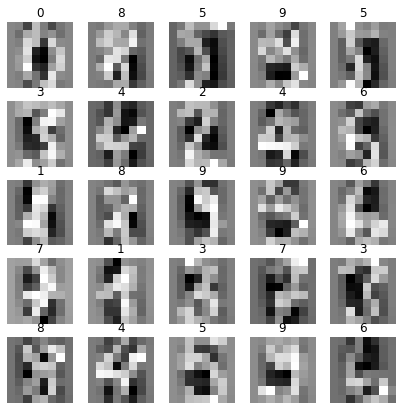

In [30]:
fig, axs = plt.subplots(5, 5, figsize=(7, 7))
for i in range(5):
    for j in range(5):
        k = np.random.randint(0, 1797)
        axs[i, j].imshow(X[k,:].reshape(8, 8), cmap='gray')
        axs[i, j].set_title(y[k])
        axs[i, j].axis('off')


In [ ]:
class my_PCA():
    def __init__(self, n_components):
        self.n_components = n_components
    
    def fit(self, X):
        X_mean = X.sum(axis=0) / X.shape[0] # axis=0 - складываем по столбцам
        X_centered = X - X_mean
        C = X_centered.transpose().dot(X_centered)
        lambdas, F = np.linalg.eigh(C)
        lambdas = lambdas[::-1]
        F = F[:, ::-1]
        
        return X_centered, lambdas, F

    def transform(self, X_centered, F):
        return X_centered.dot(F)
    
    def fit_transform(self, X):
        X_centered, _, F = self.fit(X)
        # отбрасываем все столбцы кроме первых n_components
        return self.transform(X_centered, F)[:,:self.n_components]

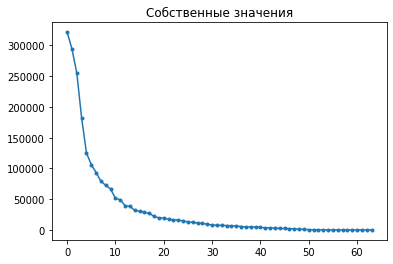

In [77]:
pca = my_PCA()

X_centered, lambdas, F = pca.fit(X)
Y = pca.transform(X_centered, F)

plt.title('Собственные значения')
plt.plot(lambdas, '.-')

0.8353053364037444


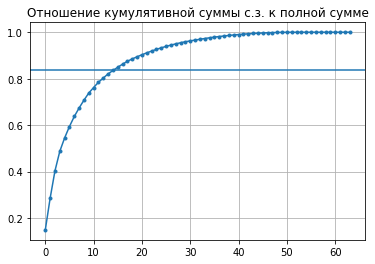

In [87]:
eig_sum = lambdas.sum()
eig_cumsum = np.cumsum(lambdas)

eig_15sum = lambdas[:15].sum() / eig_sum

plt.title('Отношение кумулятивной суммы с.з. к полной сумме')
plt.plot(eig_cumsum / eig_sum, '.-')
plt.axhline(eig_15sum)
plt.grid()
print(eig_15sum)

первые 15 главных компонент покрывают $\approx84\%$ дисперсии

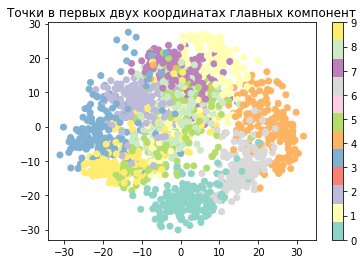

In [92]:
plt.title('Точки в первых двух координатах главных компонент')
plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap='Set3')
plt.colorbar()

Хотя классы и видно, линейно разделимыми они точно не являются

In [183]:
class my_kNN():
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors        
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, X):
        return [self.predict_one(x) for x in X]
    
    def predict_one(self, x):                
        dist = np.argsort(np.linalg.norm(x - self.X, axis=1))        
        closest_n = dist[:self.n_neighbors]        
        closest_classes = self.y[closest_n]        
        
        counts = {}        
        
        for cc in closest_classes:
            if cc in counts:
                counts[cc] += 1
            else:
                counts[cc] = 1
                
        return max(counts, key=counts.get) # ключ, соответствующий максимальному значению
        

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)

knn = my_kNN()

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy_score(y_test, y_pred)

0.9865319865319865

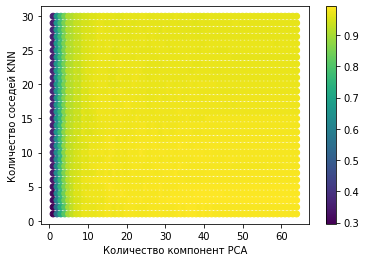

In [196]:
n_components = []
n_neighbors = []
accuracy = []

for c in range(1, 65):
    for n in range(1, 31):
        pca = my_PCA(c)

        X_reduced = pca.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.33, random_state=23)

        knn = my_kNN(n)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        score = accuracy_score(y_test, y_pred)
        
        n_components.append(c)
        n_neighbors.append(n)
        accuracy.append(score)
        
plt.scatter(n_components, n_neighbors, c=accuracy)
plt.xlabel('Количество компонент PCA')
plt.ylabel('Количество соседей KNN')
plt.colorbar()

In [214]:
best = np.argsort(accuracy)[-20:]
print(np.array(n_components)[best], np.array(n_neighbors)[best], np.array(accuracy)[best])

[39 45 54 46 41 52 44 56 51 42 34 48 64 35 50 43 49 58 47 33] [3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3] [0.99158249 0.99158249 0.99158249 0.99158249 0.99158249 0.99158249
 0.99158249 0.99158249 0.99158249 0.99158249 0.99158249 0.99158249
 0.99158249 0.99158249 0.99158249 0.99158249 0.99158249 0.99158249
 0.99158249 0.99158249]


Наибольшая точность достигается при кол-ве соседей = 3 и кол-во компонент $\geq 33$